# make a new function to make a 2D slice based on 1D Earth model (or 2D or 3D)

In [1]:
# Nobuaki Fuji Oct 2025

# breaking news! confirmed by Lorette and Stéphanie, the CMB is ellipsoidal! 
# when working with geodetic earth models, r_PREM should be corrected as a function of latitude!

using Pkg


cd(@__DIR__)
Pkg.activate("../..")
ParamFile = "../test/testparam.csv"
include("../src/batchRevise.jl") 

myInclude("../src/batchDrWatson.jl")
myInclude("../src/DSM1D.jl")
myInclude("../src/GeoPoints.jl")
using .DSM1D

  Activating project at `~/Documents/Github/flexibleDSM`
┌ Info: Including with Revise: ../src/batchDrWatson.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25
┌ Info: Including with Revise: ../src/DSM1D.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25


  0.005413 seconds (2.17 k allocations: 108.156 KiB, 74.06% compilation time)


┌ Info: Including with Revise: ../src/GeoPoints.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25


In [2]:
using Geodesy, Interpolations, StaticArrays, GMT, LinearAlgebra

In [3]:
import Base: +,-,/,*
struct GeoPoint
    lat::Float64 # in degree
    lon::Float64 # in degree
    alt::Float64 # in metre
    ecef::SVector{3,Float64}
    radius::Float64 # in metre
    #effectiveRadius::Float64 # in metre (useful to get values from 1D averaged model)
end

struct localCoord2D
    ix::Int64
    iz::Int64
    x::Float64
    z::Float64
    horizontalVector::SVector{2,Float64}
    normalVector::SVector{2,Float64}
end

struct localCoord3D
    ix::Int64
    iy::Int64
    iz::Int64
    x::Float64
    y::Float64
    z::Float64
    horizontalVector1::SVector{3,Float64}
    horizontalVector2::SVector{3,Float64}
    normalVector::SVector{3,Float64}
end

function localCoord2D(ix,iz,x,z)
    localCoord2D(ix,iz,x,z,(0.0,0.0),(0.0,0.0))
end

function GeoPoint(lat::Float64, lon::Float64; alt=0.0, ell=wgs84)
    lla = LLA(lat,lon, alt) # be careful LLA uses degrees by default!!
    ecef_coords = ECEF(lla,ell)
    radius = norm([ecef_coords.x,ecef_coords.y,ecef_coords.z])
    GeoPoint(lat, lon, alt, SVector(ecef_coords.x, ecef_coords.y, ecef_coords.z),radius)
end


function GeoPoint(ecef::SVector{3,Float64}; ell=wgs84)
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function +(a::GeoPoint,b::GeoPoint; ell=wgs84)
    ecef=a.ecef + b.ecef
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function -(a::GeoPoint,b::GeoPoint; ell=wgs84)
    ecef=a.ecef - b.ecef
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function /(a::GeoPoint,c::Real; ell=wgs84)
    ecef=a.ecef / c
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end


function *(a::GeoPoint,c::Real; ell=wgs84)
    ecef=a.ecef * c
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end


function effectiveRadius(a::GeoPoint,r0::Float64; ell=wgs84)
    radiusPlanetHere = GeoPoint(a.lat,a.lon).radius 
    ratio = r0/radiusPlanetHere
    return a.radius*ratio
end




ErrorException: invalid redefinition of constant Main.localCoord2D

In [4]:
# Example 1-D model (toy). Replace with your actual model arrays.
# r_model in meters from Earth center (0..R_ref), assume sorted ascending
R_ref = DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3                   # model reference radius (m)


6.371e6

In [5]:
# create an interpolator in radius space (ensure interpolation domain covers used r)
#r_model = collect(0.0:1000.0:R_ref)  # example radius grid
#v_model = 5000 .- 0.5 .* (R_ref .- r_model) ./ 1000;  # dummy profile
#itp = LinearInterpolation(r_model, v_model; extrapolation_bc=Flat())

In [6]:
p1 = GeoPoint(48.8566,2.3522) # Paris
p2 = GeoPoint(42.8,1.5) # Tarascon (à peu près)
#topographyFromGeoPoint(p1)
@show GeoPoint(p1.ecef)
@show p0 = (p1 + p2)/2.0


GeoPoint(p1.ecef) = GeoPoint(48.8566, 2.3522000000000003, 7.047140324999535e-10, [4.200914795649138e6, 172559.77631070156, 4.780081341967356e6], 6.366053693814456e6)
p0 = (p1 + p2) / 2.0 = GeoPoint(45.82989800475024, 1.9029714540760907, -8978.352692728113, [4.443193158578102e6, 147626.58304377226, 4.545653677986095e6], 6.358201507709939e6)


GeoPoint(45.82989800475024, 1.9029714540760907, -8978.352692728113, [4.443193158578102e6, 147626.58304377226, 4.545653677986095e6], 6.358201507709939e6)

In [7]:
# pre-definition of x-axis vector p1->p2 (normally this is not the one we want)
p2_1 = p2-p1
x_axis_tentative = (p2_1/p2_1.radius).ecef


3-element SVector{3, Float64} with indices SOneTo(3):
  0.7166970175507206
 -0.07375625720924696
 -0.693473431038555

In [8]:
# definition of z-axis vector centre -> p0

z_axis = normalize(p0.ecef)

3-element SVector{3, Float64} with indices SOneTo(3):
 0.698812888076966
 0.023218292604404035
 0.7149275895823759

In [9]:
# y-axis: complete right-handed system
y_axis = normalize(cross(z_axis, x_axis_tentative))

3-element SVector{3, Float64} with indices SOneTo(3):
  0.036629318622305354
  0.9970002078796852
 -0.06818268478968828

In [10]:
x_axis = cross(y_axis, z_axis)  # now perfectly orthogonal

3-element SVector{3, Float64} with indices SOneTo(3):
  0.7143660409585519
 -0.07383424934541309
 -0.6958661244440657

In [11]:
#Rotation matrix
R = SMatrix{3,3,Float64}(
    x_axis[1], x_axis[2], x_axis[3],
    y_axis[1], y_axis[2], y_axis[3],
    z_axis[1], z_axis[2], z_axis[3]
)

3×3 SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  0.714366    0.0366293  0.698813
 -0.0738342   0.997      0.0232183
 -0.695866   -0.0681827  0.714928

In [12]:
R*R'

3×3 SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  1.0          -7.58473e-19  -5.24145e-17
 -7.58473e-19   1.0           1.47593e-17
 -5.24145e-17   1.47593e-17   1.0

In [13]:
p_2D_to_ECEF(x_2D,z_2D,pOrigin::SVector{3,Float64},R::SMatrix{3,3,Float64}) = pOrigin+R*SVector(x_2D,0.e0,z_2D)

p_2D_to_ECEF (generic function with 1 method)

In [14]:
p_ECEF_to_2D(p_3D::SVector{3,Float64},pOrigin::SVector{3,Float64},R::SMatrix{3,3,Float64}) = R' * (p_3D - pOrigin)

p_ECEF_to_2D (generic function with 1 method)

In [15]:
p_ECEF_to_2D(p0.ecef, p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
 338046.62854124676
     -2.8438589548976056e-11
   1129.5315985638524

In [16]:
p0.ecef - p_2D_to_ECEF(p_ECEF_to_2D(p0.ecef,p1.ecef,R)[1],p_ECEF_to_2D(p0.ecef,p1.ecef,R)[3],p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
  0.0
 -2.9103830456733704e-11
  0.0

In [17]:
p0_0_above=p_2D_to_ECEF(0,0,p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
      4.200914795649138e6
 172559.77631070156
      4.780081341967356e6

In [18]:
p0_1m_above=p_2D_to_ECEF(0,1,p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
      4.200915494462026e6
 172559.79952899416
      4.780082056894946e6

In [19]:
p_ECEF_to_2D(p0_1m_above, p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
 -8.852265046769912e-12
 -5.413994677125502e-12
  0.9999999999047554

In [20]:
Δx = 50 # in metre
Δz = 50

altMax = 20000 # in metre
altMin = -100.e3 # in metre
#altMin = -5000

# since p1 and p2 can be even out of the solid Earth or inside the Earth
# I define that p1 and p2 should be the left and right limits

leftLimit = 0 # in metre so x is always non-negative
rightLimit = p2_1.radius # it is bigger than what we need ....|


676097.0312306838

In [21]:
@show Nx = Int64((rightLimit-leftLimit) ÷ Δx+1) 
@show Nz = Int64((altMax-altMin) ÷ Δz + 1 ) 

Nx = Int64((rightLimit - leftLimit) ÷ Δx + 1) = 13522
Nz = Int64((altMax - altMin) ÷ Δz + 1) = 2401


2401

In [22]:
allGridsInGeoPoints=Array{GeoPoint,2}(undef,Nx,Nz)

effectiveRadii=Array{Float64,2}(undef,Nx,Nz)

allGridsInCartesian2D=Array{localCoord2D,2}(undef,Nx,Nz)

seismicModel2D=(ρ=zeros(Float64,Nx,Nz),Vpv=zeros(Float64,Nx,Nz),Vph=zeros(Float64,Nx,Nz),Vsv=zeros(Float64,Nx,Nz),Vsh=zeros(Float64,Nx,Nz),Qμ=zeros(Float64,Nx,Nz),Qκ=zeros(Float64,Nx,Nz),QμPower=zeros(Float64,Nx,Nz),QκPower=zeros(Float64,Nx,Nz),η=zeros(Float64,Nx,Nz))

for iXZ in CartesianIndices(allGridsInGeoPoints)
    ix, iz = Tuple(iXZ)
    x = leftLimit+(ix-1)*Δx
    z = altMin+(iz-1)*Δz 
    tmpGeoPoint=GeoPoint(p_2D_to_ECEF(x,z,p1.ecef,R))
    
    allGridsInGeoPoints[iXZ]=tmpGeoPoint

    allGridsInCartesian2D[iXZ]=localCoord2D(ix,iz,x,z)
  
    effectiveRadii[iXZ]=effectiveRadius(tmpGeoPoint,DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3 )
end


MethodError: MethodError: Cannot `convert` an object of type Int64 to an object of type SVector{2, Integer}
The function `convert` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  (::Type{SA})(::Any...) where SA<:StaticArray
   @ StaticArrays ~/.julia/packages/StaticArrays/DsPgf/src/convert.jl:173
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:126
  convert(::Type{SA}, !Matched::AbstractArray) where SA<:StaticArray
   @ StaticArrays ~/.julia/packages/StaticArrays/DsPgf/src/convert.jl:207
  ...


In [23]:
DSM1D.my1DDSMmodel.C_Qκ

12×4 Matrix{Float64}:
  1327.7  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0

# about effectiveRadii corrections

In fact, there are three types of parameter modification, based on 1D planet models. 

(i) Changing effectiveRadii by the function effectiveRadius, considering the ellipticity of the planet (which is done above).

(ii) changing a topography of discontinuity (CMB, 410 or 660-km, solid-air surface), which can be further be done by changing effectiveRadii locally.

(iii) introducing a new layer (ocean or something that could exist only at some region in terms of lat and lon).


Reading the topo file can give the solid-air surface (option ii) and solid-liquid surface (option iii) so we need to separate the two of them.


The idea is to read topo for (ii) and (iii) and provide a interpolator for effectiveRadii first. Then (iii) can be done by overwriting the params matrix.

In [24]:
# now I need to use GMT.jl to get the topography

lats = [p.lat for p in allGridsInGeoPoints]
lons = [p.lon for p in allGridsInGeoPoints]

lat_min, lat_max = extrema(lats)
lon_min, lon_max = extrema(lons)
if lat_min === lat_max
    if lat_min > 1.0
        lat_min = lat_min - 0.5
    else
        lat_max = lat_max + 0.5
    end
end

if lon_min === lon_max
    if lon_min > 1.0
        lon_min = lon_min - 0.5
    else
        lon_max = lon_max + 0.5
    end
end

lat_min, lat_max,lon_min,lon_max

(0.0, 48.907887632772656, 0.0, 2.359796896592829)

In [25]:
function GMTprecision(requiredResolutionInKmÀPeuPrès::Float64)
    if requiredResolutionInKmÀPeuPrès > 55.0
        return "@earth_relief_30m"
    elseif  18.0 < requiredResolutionInKmÀPeuPrès <= 55.0
        return "@earth_relief_10m"
    elseif  9.0 < requiredResolutionInKmÀPeuPrès <= 18.0
        return "@earth_relief_05m"
    elseif 3.6 < requiredResolutionInKmÀPeuPrès <= 9.0
        return "@earth_relief_02m"
    elseif 1.8 < requiredResolutionInKmÀPeuPrès <= 3.6
        return "@earth_relief_01m"
    elseif 0.45 < requiredResolutionInKmÀPeuPrès <= 1.8
        return "@earth_relief_15s"
    elseif 0.30 < requiredResolutionInKmÀPeuPrès <= 0.45
        return "@earth_relief_10s"
    elseif 0.15 < requiredResolutionInKmÀPeuPrès <= 0.30
        return "@earth_relief_02s"
    elseif 0.09 < requiredResolutionInKmÀPeuPrès <= 0.15
        return "@earth_relief_03s"
    elseif 0.06 < requiredResolutionInKmÀPeuPrès <= 0.09
        return "@earth_relief_02s"
    else
        return "@earth_relief_01s"
        # after this
        """
        # Load your own local DEM (GeoTIFF, etc.)
        topo = GMT.read("Copernicus_DSM_30m_Europe.tif")

        # Cut a region and maybe downsample
        region = [-5, 0, 43, 47]
        topo_sub = GMT.grdcut(topo, region=region)

        # Optional resampling (to ~10 m)
        topo_10m = GMT.grdsample(topo_sub, inc="10m")

        """
    end
end

                  

GMTprecision (generic function with 1 method)

In [26]:


using GMT,CairoMakie

#region = [lon_min, lon_max, lat_min, lat_max]
region = [-10,20,35,60]
precision = GMTprecision(0.5) # this should be in Km



# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.
topoEuro = GMT.grdcut(precision, region=region)

topoEuro_surface = copy(topoEuro.z)
topoEuro_bathymetry = copy(topoEuro.z)


6000×7200 Matrix{Float32}:
 -4274.0  -4274.5  -4275.0  -4274.0  …  -3012.5  -3005.5  -2999.0  -2992.5
 -4278.0  -4276.5  -4275.0  -4273.5     -3009.5  -3005.0  -2999.5  -2993.5
 -4276.5  -4275.0  -4273.5  -4272.0     -3006.5  -3004.0  -3000.0  -2994.0
 -4276.0  -4274.5  -4273.0  -4271.5     -3005.5  -3004.0  -3002.5  -3000.0
 -4276.0  -4274.0  -4271.5  -4270.0     -3005.0  -3004.5  -3005.0  -3007.0
 -4274.5  -4272.0  -4270.0  -4269.5  …  -3001.0  -3004.0  -3007.5  -3013.5
 -4272.0  -4269.5  -4268.0  -4267.5     -2997.0  -3001.0  -3006.0  -3019.5
 -4270.0  -4268.0  -4266.0  -4265.0     -2997.0  -3003.0  -3010.5  -3017.0
 -4270.0  -4269.0  -4267.5  -4266.0     -2995.5  -3002.5  -3009.5  -3013.0
 -4269.0  -4269.0  -4268.0  -4266.5     -2991.5  -3000.0  -3009.0  -3010.0
     ⋮                               ⋱                             
 -1120.0  -1116.5  -1114.5  -1113.0       -32.0    -30.5    -30.5    -31.0
 -1108.0  -1104.0  -1104.5  -1104.0       -30.0    -25.0    -23.5    -21.0
 -110

In [27]:
topoEuro_surface[topoEuro_surface .< 0.0 ] .= 0.0
topoEuro_bathymetry[topoEuro_bathymetry .> 0.0 ] .= 0.0

22472070-element view(::Vector{Float32}, [3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994  …  43198786, 43198787, 43198788, 43198789, 43198790, 43198791, 43199996, 43199997, 43199998, 43199999]) with eltype Float32:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

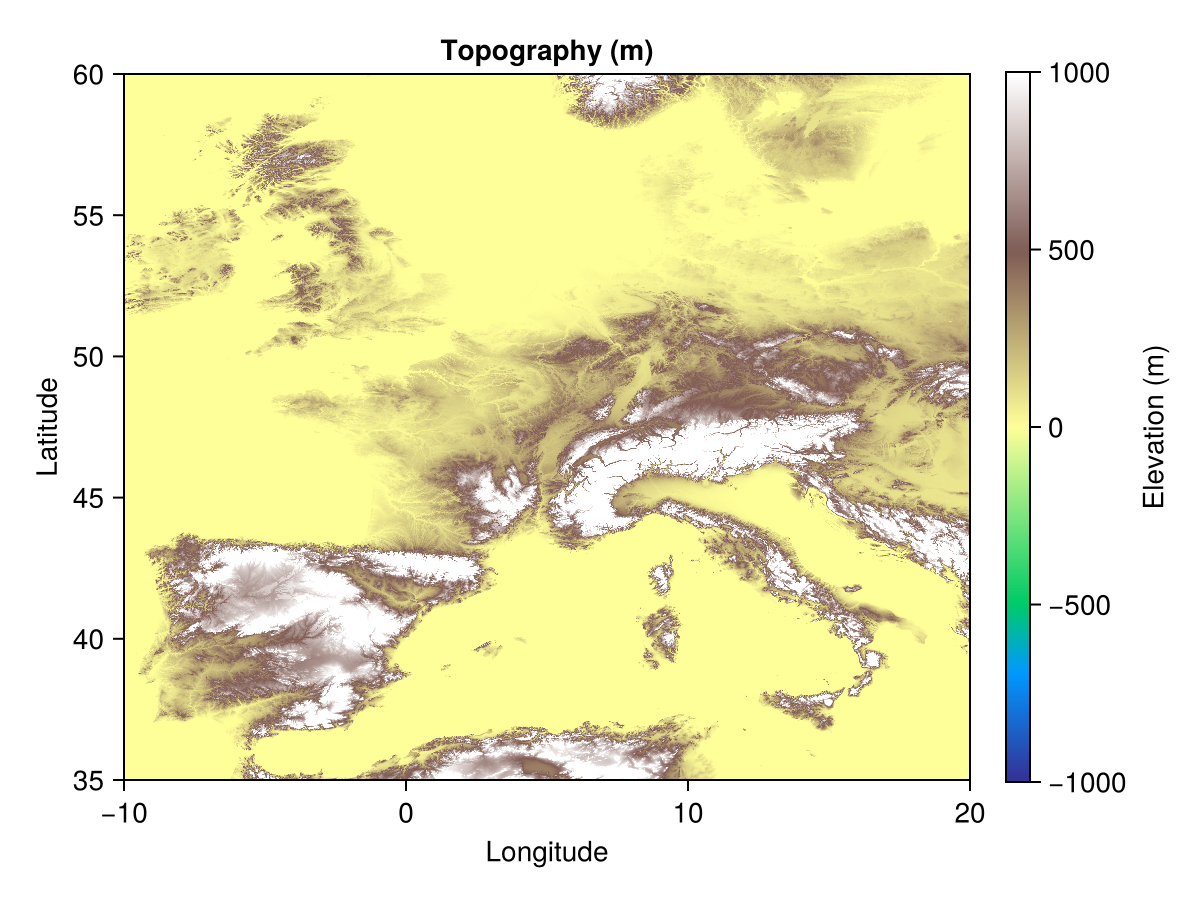

In [28]:


fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    topoEuro.x,topoEuro.y,topoEuro_surface';
    colormap = :terrain,
    colorrange=(-1000,1000),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

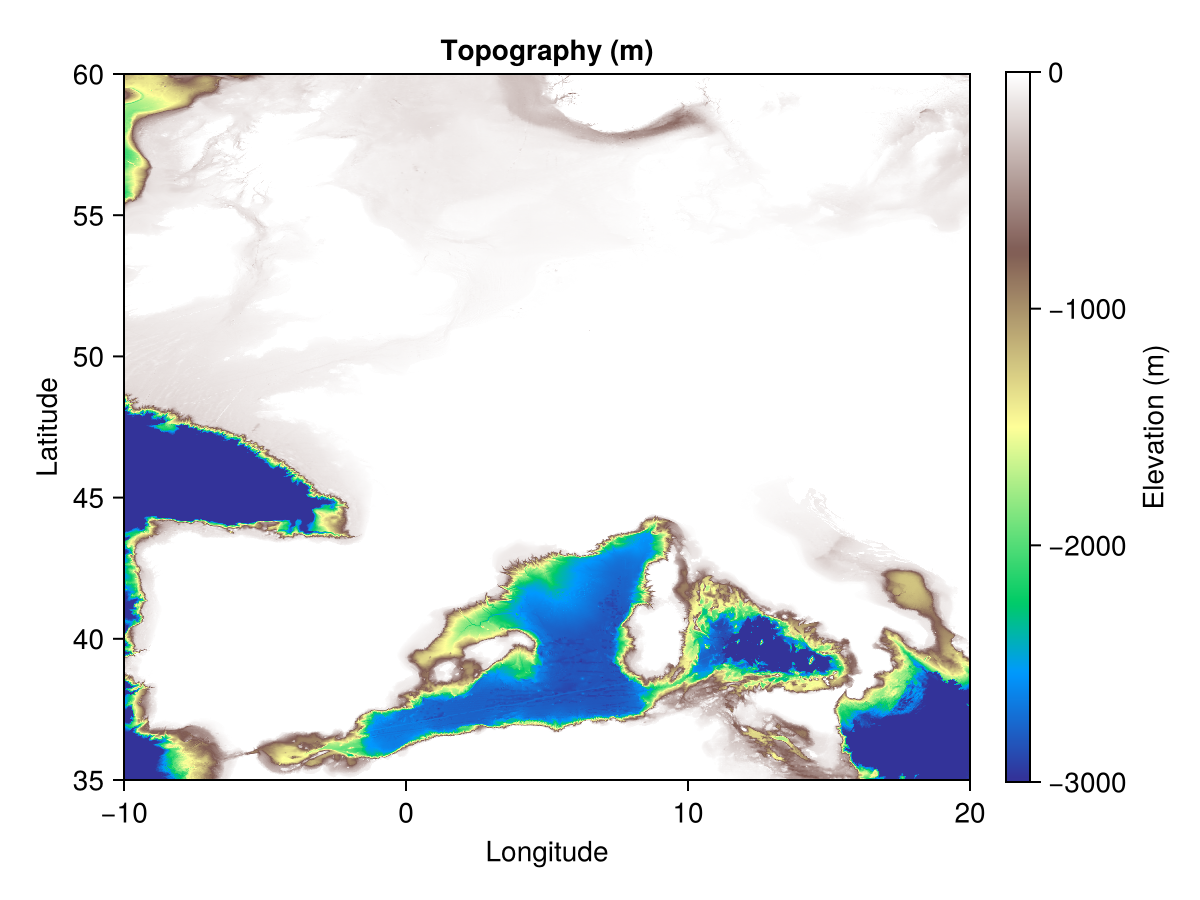

In [29]:


fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    topoEuro.x,topoEuro.y,topoEuro_bathymetry';
    colormap = :terrain,
    colorrange=(-3000,0),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

In [30]:
using GMT,CairoMakie

region = [lon_min, lon_max, lat_min, lat_max]

precision = GMTprecision(0.03)
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.
topo = GMT.grdcut(precision, region=region)
topo_surface = copy(topo.z)
topo_bathymetry = copy(topo.z)
fig, ax, hm = heatmap(
    topo.x,topo.y,topo.z';
    colormap = :terrain,
    colorrange=(0,800),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

grdblend [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]

grdblend [NOTICE]: Earth Relief at 1x1 arc seconds tiles provided by SRTMGL1 (land only) [NASA/USGS].
grdblend [NOTICE]:   -> Download 1x1 degree grid tile (earth_relief_01s_g): N05E000
ERROR 1: read: segment too long (829) with max (12371) for codeblock 15 (p=0, b=0, r=3, c=0)

ERROR 1: Failed to decode.

ERROR 1: opj_get_decoded_tile() failed
ERROR 1: N43E001.earth_relief_01s_g.jp2, band 1: IReadBlock failed at X offset 2, Y offset 1: opj_get_decoded_tile() failed
ERROR 1: Stream too short

ERROR 1: Stream too short

ERROR 1: Stream too short

ERROR 1: opj_get_decoded_tile() failed
ERROR 1: opj_get_decoded_tile() failed
ERROR 1: opj_get_decoded_tile() failed
ERROR 1: read: segment too long (829) with max (12371) for codeblock 15 (p=0, b=0, r=3, c=0)

ERROR 1: Failed to decode.

ERROR 1: opj_get_decoded_tile() failed
ERROR 1: Stream too short

ERROR 1: opj_get_decoded_tile() 

In [31]:
topo.y

176071-element Vector{Float64}:
  0.0
  0.0002777777777777778
  0.0005555555555555556
  0.0008333333333333334
  0.0011111111111111111
  0.001388888888888889
  0.0016666666666666668
  0.0019444444444444444
  0.0022222222222222222
  0.0025
  ⋮
 48.90611111111111
 48.90638888888889
 48.906666666666666
 48.90694444444444
 48.907222222222224
 48.9075
 48.90777777777778
 48.908055555555556
 48.90833333333333

In [32]:
# First we take care of topo_surface

topoInterpolater = interpolate((topo.y,topo.x),topo_surface,Gridded(Linear()));

In [33]:
eps = 100.0 # in metre "below" option should be enough but who knows
for iXZ in CartesianIndices(allGridsInGeoPoints)
    tmpPoint = allGridsInGeoPoints[iXZ]
    if 0.0 <= tmpPoint.alt <= topoInterpolater(tmpPoint.lat,tmpPoint.lon) 
        # it might be very time-consuming if we do this for 3D Cartesian points ...
        effectiveRadii[iXZ]=DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3 - eps
    end
end

# note

in order to remove eps above, I need to understand interpolate.jl bit more (in the presence of discontinuities)

In [36]:
# make a regular grid for the necessary radii
NradiusNodes =500 # I don't know how to make this number reasonable
tmpNradiusNodes = NradiusNodes
if NradiusNodes === 1
    tmpNradiusNodes = 1
end

ΔradiusIncrementInKm = (maximum(effectiveRadii)-minimum(effectiveRadii))/(tmpNradiusNodes-1) *1.e-3
linearRadiiInKm =(collect(1:1:NradiusNodes) .- 1)*ΔradiusIncrementInKm .+ minimum(effectiveRadii)*1.e-3

push!(linearRadiiInKm, DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer) # here I put the most important discontinuity but maybe I need to add all vmin inside, the order will be sorted so we don't


501-element Vector{Float64}:
    0.0
   12.767334669338677
   25.534669338677354
   38.30200400801603
   51.06933867735471
   63.83667334669339
   76.60400801603205
   89.37134268537073
  102.13867735470942
  114.9060120240481
    ⋮
 6281.528657314629
 6294.295991983968
 6307.063326653307
 6319.830661322645
 6332.597995991984
 6345.365330661322
 6358.132665330661
 6370.9
 6371.0

In [37]:
newRadii,params=DSM1D.compute1DseismicParamtersFromPolynomialCoefficientsWithGivenRadiiArray(DSM1D.my1DDSMmodel,linearRadiiInKm,"below")

([0.0, 12.767334669338677, 25.534669338677354, 38.30200400801603, 51.06933867735471, 63.83667334669339, 76.60400801603205, 89.37134268537073, 102.13867735470942, 114.9060120240481  …  6268.76132264529, 6281.528657314629, 6294.295991983968, 6307.063326653307, 6319.830661322645, 6332.597995991984, 6345.365330661322, 6358.132665330661, 6370.9, 6371.0], (ρ = [13.0885, 13.088464506879271, 13.088358027517089, 13.088180561913449, 13.087932110068353, 13.087612671981802, 13.087222247653795, 13.086760837084332, 13.086228440273414, 13.08562505722104  …  3.3722887050383923, 3.3736762584091426, 3.375063811779893, 3.3764513651506434, 3.3778389185213937, 3.379226471892144, 3.380614025262894, 2.6, 2.6, 2.6], Vpv = [11.2622, 11.262174442672032, 11.26209777068813, 11.26196998404829, 11.261791082752515, 11.261561066800805, 11.261279936193159, 11.260947690929576, 11.26056433101006, 11.260129856434608  …  7.933869082852566, 7.948333785668966, 7.962798488485367, 7.977263191301768, 7.991727894118168, 8.00619

In [38]:
itp_ρ = LinearInterpolation(newRadii.*1.e3,params.ρ; extrapolation_bc=Flat())
# I know that I don't have to copy this for all the parameters, Hesaneh, you can find an elegant way to do this for vpv, vph etc. with one line!

501-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Flat()) with element type Float64:
 13.0885
 13.088464506879271
 13.088358027517089
 13.088180561913449
 13.087932110068353
 13.087612671981802
 13.087222247653795
 13.086760837084332
 13.086228440273414
 13.08562505722104
  ⋮
  3.3736762584091426
  3.375063811779893
  3.3764513651506434
  3.3778389185213937
  3.379226471892144
  3.380614025262894
  2.6
  2.6
  2.6

In [39]:
#seismicModel2D=(ρ=zeros(Float64,Nx,Nz),Vpv=zeros(Float64,Nx,Nz),Vph=zeros(Float64,Nx,Nz),Vsv=zeros(Float64,Nx,Nz),Vsh=zeros(Float64,Nx,Nz),Qμ=zeros(Float64,Nx,Nz),Qκ=zeros(Float64,Nx,Nz),QμPower=zeros(Float64,Nx,Nz),QκPower=zeros(Float64,Nx,Nz),η=zeros(Float64,Nx,Nz))
for iXZ in CartesianIndices(allGridsInGeoPoints)
    seismicModel2D.ρ[iXZ]= itp_ρ(effectiveRadii[iXZ])
end

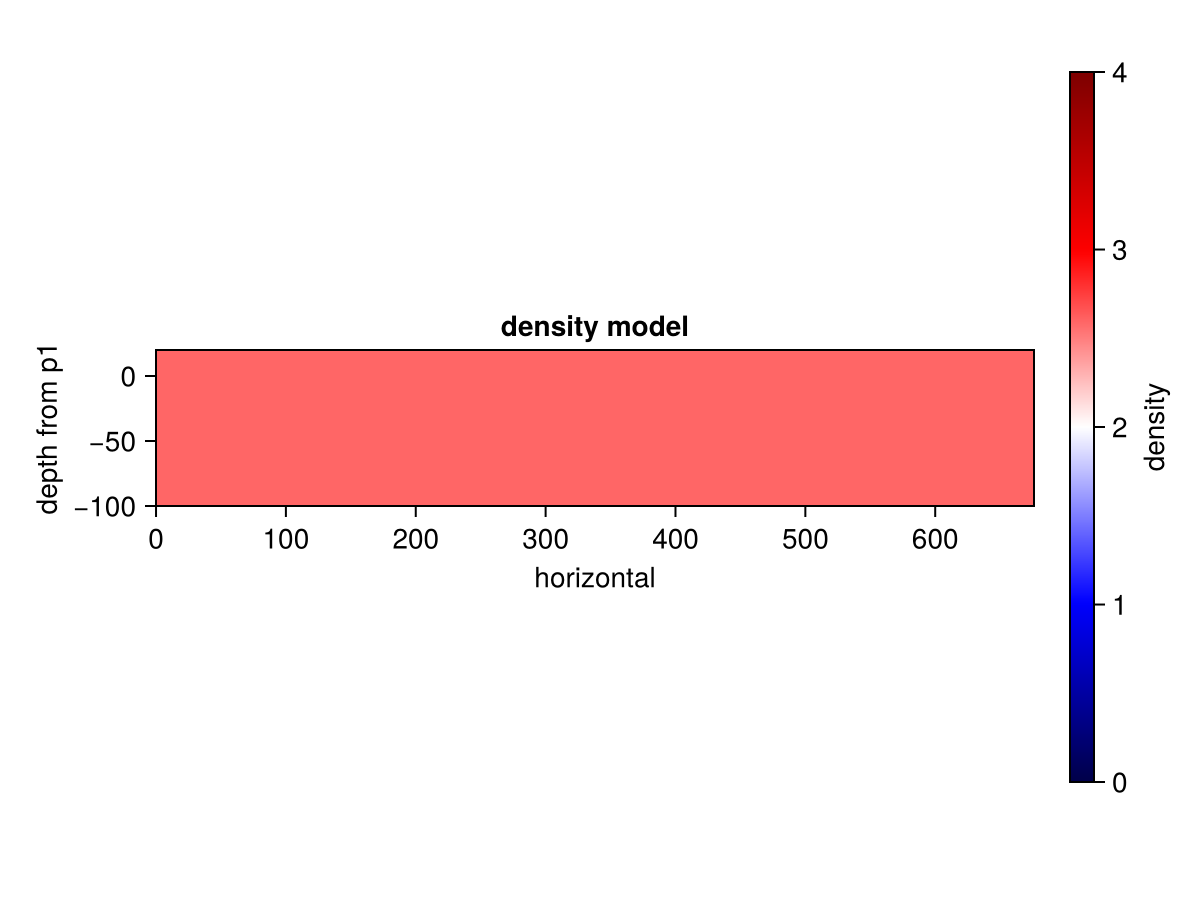

In [40]:
fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    collect((0:1:(Nx-1)).*Δx).*1.e-3,(collect(0:1:(Nz-1)).*Δz.+altMin).*1.e-3, seismicModel2D.ρ;
    colormap = :seismic,
    colorrange=(0,4),
    axis = (aspect = DataAspect(), xlabel = "horizontal", ylabel = "depth from p1", title = "density model")
)
Colorbar(fig[1,2], hm, label="density")
#ylims!(ax,-50,50)
#xlims!(ax,600,700)
fig

# I need to do (iii) for the water

In [44]:
radii,params=DSM1D.compute1DseismicParamtersFromPolynomialCoefficientsWithGivenRadiiArray(DSM1D.my1DDSMmodel,myRadiiArray,"below")
params.Vph

UndefVarError: UndefVarError: `myRadiiArray` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [45]:
allGridsInGeoPoints[1,1]

GeoPoint(48.907887632772656, 2.359796896592829, -99838.236349905, [4.1310335068414416e6, 170237.94705026117, 4.708588583009119e6], 6.266197031478216e6)

In [46]:
effectiveRadii[200,1]

6.3709e6

In [47]:
params.ρ

501-element Vector{Float64}:
 13.0885
 13.088464506879271
 13.088358027517089
 13.088180561913449
 13.087932110068353
 13.087612671981802
 13.087222247653795
 13.086760837084332
 13.086228440273414
 13.08562505722104
  ⋮
  3.3736762584091426
  3.375063811779893
  3.3764513651506434
  3.3778389185213937
  3.379226471892144
  3.380614025262894
  2.6
  2.6
  2.6

In [49]:
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.

# I need to : 
add local coordinates and normals at each point as options to GeoPoint


In [51]:

# Extract coordinates from GeoPoints
lons = [p.lon for p in allGridsInGeoPoints[:]]
lats = [p.lat for p in allGridsInGeoPoints[:]]


32466322-element Vector{Float64}:
 48.907887632772656
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [52]:

# Query the topography via grdtrack using the file path
topo_vals = GMT.grdtrack(lons, lats; G=tmpfile,show=false)

UndefVarError: UndefVarError: `tmpfile` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [53]:


# Reshape back to 2D
Nx, Nz = size(allGridsInGeoPoints)
topo_vals_2D = reshape(topo_vals, Nx, Nz)


UndefVarError: UndefVarError: `topo_vals` not defined in `Main`
Suggestion: check for spelling errors or missing imports.